In [46]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [47]:
def load_image_datasets(
    root_dir, 
    img_size=(224,224), 
    batch_size=32,
    val_split=0.2,
    subset_seed=42, 
    color_mode='rgb', 
    preprocess_fn=None,
    shuffle=True,
    class_names=None
):  
    train_ds = image_dataset_from_directory(
        root_dir,
        labels='inferred',
        label_mode='categorical',
        class_names=class_names,
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=subset_seed,
        validation_split=val_split,
        subset='training',
        color_mode=color_mode
    )
    val_ds = image_dataset_from_directory(
        root_dir,
        labels='inferred',
        label_mode='categorical',
        class_names=class_names,
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=subset_seed,
        validation_split=val_split,
        subset='validation',
        color_mode=color_mode
    )

    the_classes = train_ds.class_names
    
    if preprocess_fn is not None:
        train_ds = train_ds.map(lambda x, y: (preprocess_fn(x), y), 
                               num_parallel_calls=tf.data.AUTOTUNE)
        val_ds = val_ds.map(lambda x, y: (preprocess_fn(x), y), 
                             num_parallel_calls=tf.data.AUTOTUNE)
        
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, the_classes

In [48]:
img_size = (224, 224)
batch_size = 32

In [49]:
preprocess_fn = keras.applications.resnet.preprocess_input

In [50]:
dataset_path = '../datasets/animals'

In [51]:
train_dataset, val_dataset, class_names = load_image_datasets(
    root_dir=dataset_path,
    img_size=img_size,
    batch_size=batch_size,
    val_split=0.2,
    preprocess_fn=preprocess_fn,
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [52]:
class_names

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [53]:
def deprocess_img(img, preprocess_type="resnet"):
    img = img.copy()
    if preprocess_type == "resnet":
        img[..., 0] += 103.939
        img[..., 1] += 116.779
        img[..., 2] += 123.68
        img = img[..., ::-1]
    elif preprocess_type == "inception":
        img = ((img + 1.0) * 127.5)
    elif preprocess_type == "mobilenet":
        img = ((img + 1.0) * 127.5)
    elif preprocess_type == "none":
        img = img * 255.0
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [54]:
def visualize_batch(
    batch_images, batch_labels, class_names, 
    n=20, random_select=True, preprocess_type="resnet"
):
    if isinstance(batch_images, tf.Tensor):
        batch_images = batch_images.numpy()
        batch_labels = batch_labels.numpy()
    if batch_images.shape[-1] == 1 and len(batch_images.shape) == 4:
        batch_images = np.concatenate([batch_images]*3, axis=-1)
    if batch_labels.ndim > 1 and batch_labels.shape[-1] > 1:
        batch_labels = np.argmax(batch_labels, axis=-1)
        
    count = min(n, batch_images.shape[0])
    if random_select:
        idxs = random.sample(range(batch_images.shape[0]), count)
    else:
        idxs = list(range(count))

    cols = 5
    rows = (count + cols - 1) // cols
    plt.figure(figsize=(15, 3 * rows))

    for i, idx in enumerate(idxs):
        img = deprocess_img(batch_images[idx], preprocess_type)
        label = batch_labels[idx]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f'Class: {class_names[label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [55]:
def visualize_from_dataset(
    ds, class_names, n=20, preprocess_type="resnet", random_select=True
):
    batch_images, batch_labels = next(iter(ds))
    visualize_batch(batch_images, batch_labels, class_names, n=n, random_select=random_select, preprocess_type=preprocess_type)

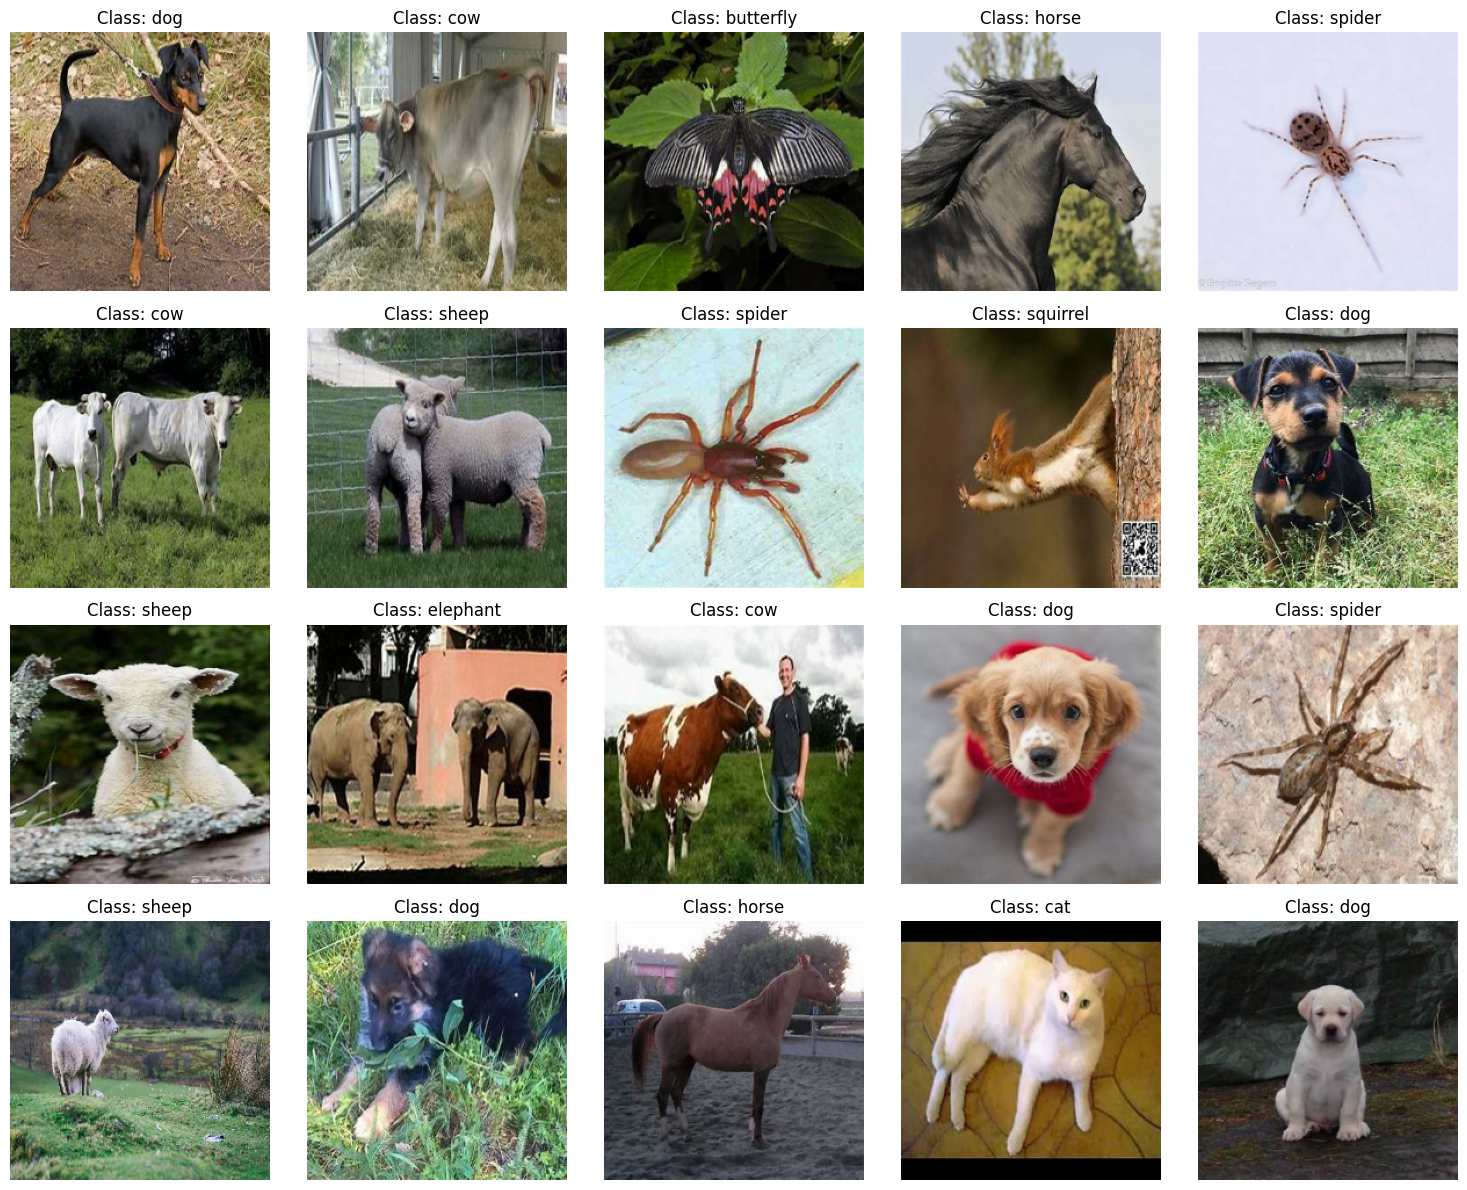

In [56]:
visualize_from_dataset(train_dataset, class_names, n=20, preprocess_type="resnet")

In [57]:
base_model = keras.applications.ResNet152(include_top=False, input_shape=(224, 224, 3))

In [58]:
for i in base_model.layers:
    i.trainable = False

In [59]:
inputs = Input(shape=(224, 224, 3))
model_layer = base_model(inputs)
avr_pool = GlobalAveragePooling2D()(model_layer)
dense = Dense(128, activation='relu')(avr_pool)
outputs = Dense(len(class_names), activation='softmax')(dense)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152 (Functional)               │ (None, 7, 7, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,634,506 (223.67 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [60]:
epochs = 4
STEPS_PER_EPOCH = 125
VALIDATION_STEPS = 35

In [61]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
)

Epoch 1/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.9090 - loss: 0.3150 - val_accuracy: 0.9598 - val_loss: 0.1743
Epoch 2/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - accuracy: 0.9503 - loss: 0.1774 - val_accuracy: 0.9652 - val_loss: 0.1251
Epoch 3/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.9542 - loss: 0.1540 - val_accuracy: 0.9696 - val_loss: 0.1302
Epoch 4/4
125/125 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.9655 - loss: 0.1226 - val_accuracy: 0.9696 - val_loss: 0.1083


In [65]:
def analyze_predictions(
    model, ds, class_names, batch_size=32, preprocess_type="resnet", max_errors=20, max_samples=500
):
    y_true, imgs = [], []
    count = 0
    for batch_images, batch_labels in ds:
        if isinstance(batch_images, tf.Tensor):
            batch_images_np = batch_images.numpy()
            imgs.append(batch_images_np)
        else:
            imgs.append(batch_images)
        batch_labels_np = batch_labels.numpy() if isinstance(batch_labels, tf.Tensor) else batch_labels
        if batch_labels_np.ndim > 1 and batch_labels_np.shape[-1] > 1:
            y_true.extend(np.argmax(batch_labels_np, axis=-1))
        else:
            y_true.extend(batch_labels_np)
        count += len(batch_images_np)
        if count >= max_samples:
            break
    imgs = np.concatenate(imgs, axis=0)[:max_samples]
    y_true = np.array(y_true)[:max_samples]
    input_sample_ds = tf.data.Dataset.from_tensor_slices(imgs).batch(batch_size)
    y_pred_probs = model.predict(input_sample_ds, verbose=0)
    if y_pred_probs.shape[-1] == 1:
        y_pred = (y_pred_probs > 0.5).astype("int").flatten()
    else:
        y_pred = np.argmax(y_pred_probs, axis=-1)
    acc = np.mean(y_pred == y_true)
    print(f"Test accuracy: {acc:.4f}")
    print("Predictions:", y_pred[:10])
    print("True labels:", y_true[:10])
    errors = np.where(y_pred != y_true)[0]
    print(f"Mistakes: {len(errors)}/{len(y_true)}")

    plt.figure(figsize=(12, 7))
    n_plot = min(max_errors, len(errors))
    cols = 5
    rows = (n_plot + cols - 1) // cols
    for n, idx in enumerate(errors[:n_plot]):
        img = deprocess_img(imgs[idx], preprocess_type)
        plt.subplot(rows, cols, n + 1)
        plt.imshow(img)
        p_label = class_names[y_pred[idx]]
        t_label = class_names[y_true[idx]]
        plt.title(f'Pred: {p_label}\nTrue: {t_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Test accuracy: 0.9600
Predictions: [3 4 3 0 2 1 0 5 5 8]
True labels: [2 6 3 0 2 1 0 5 5 8]
Mistakes: 20/500


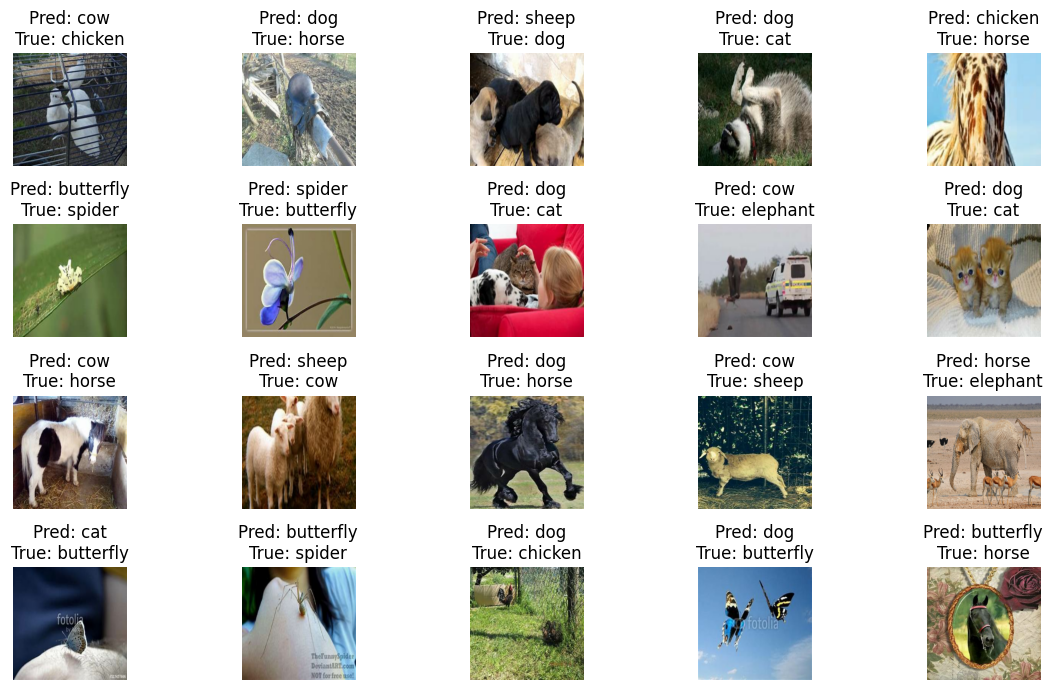

In [67]:
analyze_predictions(model, val_dataset, class_names, max_errors=20, max_samples=500)